Imports & configs

In [39]:
# --- Cell 1: Imports & config ---
import os, json, math, warnings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap  
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, mode
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")

# Paths
WEEK3_DIR = Path.cwd().resolve()

# Load Week 2 output (synthetic paths are now in Week 3 folder)
cube = np.load(WEEK3_DIR / "synthetic_paths_20d.npy")   # shape (N, H, A)
print("Loaded cube:", cube.shape)


Loaded cube: (5000, 20, 10)


Extended Feature Engineering

In [40]:
# --- Cell 2: Extended Feature Engineering (robust) ---
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import skew, kurtosis

def cross_sectional_mean_corr(scn_matrix: np.ndarray) -> float:
    """
    Average cross-sectional correlation across assets for one scenario,
    computed using the full scenario window (assets × assets corr).
    scn_matrix: shape (H_days, A_assets)
    """
    if scn_matrix.ndim != 2:
        return np.nan
    H, A = scn_matrix.shape
    if A < 2 or H < 2:
        return np.nan
    try:
        C = np.corrcoef(scn_matrix.T)  # shape (A, A)
        if C.ndim != 2 or C.shape[0] != A:
            return np.nan
        off = C[np.triu_indices(C.shape[0], k=1)]
        return float(np.nanmean(off)) if np.isfinite(off).any() else np.nan
    except Exception:
        return np.nan

def ewma_volatility(ret_seq: np.ndarray, span: int = 10) -> float:
    """
    EWMA volatility as a lightweight proxy for volatility clustering.
    Returns the average EWMA sigma across the window.
    """
    s = pd.Series(ret_seq)
    var_ewm = (s - s.mean()).pow(2).ewm(span=span, adjust=False).mean()
    sig_ewm = np.sqrt(var_ewm)
    return float(sig_ewm.mean())

def garch_volatility(ret_seq: np.ndarray) -> float:
    """
    GARCH(1,1) variance estimate. Often unstable for H=20; may return NaN.
    """
    try:
        am = sm.tsa.arch_model(ret_seq, mean="zero", vol="GARCH", p=1, q=1)
        res = am.fit(disp="off")
        return float(res.conditional_volatility.mean())
    except Exception:
        return np.nan

def drawdown_stats(ret_seq: np.ndarray):
    """
    Return (max drawdown, drawdown duration in days).
    """
    equity = (1 + pd.Series(ret_seq)).cumprod()
    running_max = equity.cummax()
    dd = equity / running_max - 1
    max_dd = float(dd.min())
    below = dd < 0
    duration = int((below * (np.arange(len(below)) -
                             np.maximum.accumulate(~below * np.arange(len(below))))).max())
    return max_dd, duration

def scenario_feature_vector_extended(scn_matrix: np.ndarray, w: np.ndarray | None = None) -> dict:
    """
    Compute extended scenario-level features for one scenario.
    scn_matrix: array shape (H_days, A_assets)
    """
    assert scn_matrix.ndim == 2, "scn_matrix must be 2-D (H × A)"
    H, A = scn_matrix.shape
    if w is None:
        w = np.ones(A) / A
    # equal-weight portfolio daily returns
    port_ret = scn_matrix @ w

    port_mu   = float(port_ret.mean())
    port_std  = float(port_ret.std(ddof=1))
    port_skew = float(skew(port_ret))
    port_kurt = float(kurtosis(port_ret))
    mdd, dd_dur = drawdown_stats(port_ret)

    # Vol clustering proxies
    garch_var = garch_volatility(port_ret)         # may be NaN for H=20
    ewma_sig  = ewma_volatility(port_ret, span=10) # robust proxy

    xcorr = cross_sectional_mean_corr(scn_matrix)

    return {
        "port_mean":   port_mu,
        "port_std":    port_std,
        "port_skew":   port_skew,
        "port_kurt":   port_kurt,
        "port_mdd":    mdd,
        "dd_duration": dd_dur,
        "garch_var":   garch_var,   # drop if entirely NaN later
        "ewma_vol":    ewma_sig,    # keep
        "xsec_corr":   xcorr,
    }


Build Feature Matrix (with robust NaN handling

⚠️ garch_var is NaN for all scenarios → dropping column.
Remaining NaNs per column:
 port_mean      0
port_std       0
port_skew      0
port_kurt      0
port_mdd       0
dd_duration    0
ewma_vol       0
xsec_corr      0
dtype: int64


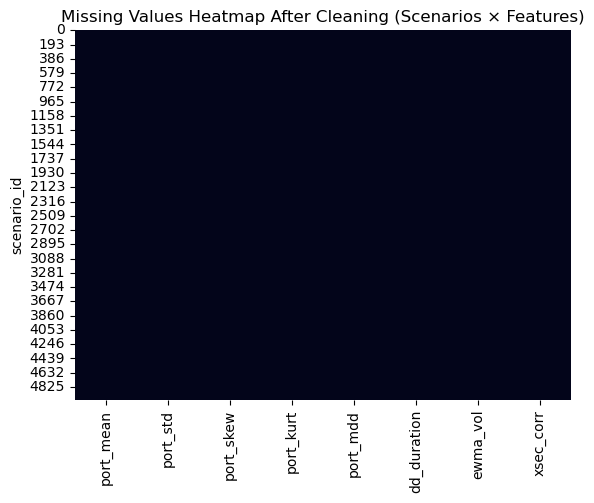

,port_mean,port_std,port_skew,port_kurt,port_mdd,dd_duration,ewma_vol,xsec_corr
scenario_id,,,,,,,,
0,0.000987,0.000153,-0.405166,-0.116321,0.0,0,0.000158,0.124892
1,0.000998,0.000148,0.083309,0.097586,0.0,0,0.000119,0.025919
2,0.000989,0.000094,0.086242,-1.110598,0.0,0,0.000075,-0.017782
3,0.001004,0.000158,0.126728,-0.722098,0.0,0,0.000172,0.189348
4,0.000953,0.000160,0.205720,-0.528932,0.0,0,0.000124,0.210932


In [41]:
# --- Cell 3: Build Feature Matrix (with robust NaN handling) ---
# Sanity on the scenario cube
assert cube.ndim == 3, f"Expected cube to be 3-D (N,H,A), got shape {cube.shape}"

features = []
for sid in range(cube.shape[0]):
    feats = scenario_feature_vector_extended(cube[sid, :, :])
    feats["scenario_id"] = sid
    features.append(feats)

feat_df = pd.DataFrame(features).set_index("scenario_id").sort_index()

# Handle garch_var: drop if all NaN, else median-impute NaNs
if "garch_var" in feat_df.columns:
    if feat_df["garch_var"].isna().all():
        print("⚠️ garch_var is NaN for all scenarios → dropping column.")
        feat_df.drop(columns=["garch_var"], inplace=True)
    elif feat_df["garch_var"].isna().any():
        med = float(feat_df["garch_var"].median())
        feat_df["garch_var"].fillna(med, inplace=True)
        print(f"⚠️ Missing garch_var values imputed with median = {med:.6f}")

# Failsafe: if any other feature has NaN, median-impute
if feat_df.isna().any().any():
    for c in feat_df.columns:
        if feat_df[c].isna().any():
            med = float(feat_df[c].median())
            feat_df[c].fillna(med, inplace=True)
            print(f"Imputed NaNs in {c} with median = {med:.6f}")

print("Remaining NaNs per column:\n", feat_df.isna().sum())

# Visual check
sns.heatmap(feat_df.isna(), cbar=False)
plt.title("Missing Values Heatmap After Cleaning (Scenarios × Features)")
plt.show()

feat_df.head()


Bootstrap Stability & ARI

In [ ]:
# --- Cell 4: Bootstrap Stability & ARI  ---

# Ensure we have a NumPy view for algorithms that expect arrays
X_arr = Xz.values if hasattr(Xz, "values") else np.asarray(Xz)

B = 10
boot_lbls = []
for b in range(B):
    idx = np.random.choice(X_arr.shape[0], size=X_arr.shape[0], replace=True)
    # fit on bootstrap sample
    km_b = KMeans(n_clusters=3, random_state=42+b, n_init=20).fit(X_arr[idx])
    # "project" those centers back on full data to get labels for all points
    km_full = KMeans(n_clusters=3,
                     init=km_b.cluster_centers_,
                     n_init=1, max_iter=1,
                     random_state=42+b).fit(X_arr)
    boot_lbls.append(km_full.labels_)

boot_lbls = np.vstack(boot_lbls)  # shape (B, N)

# Pairwise ARI across bootstrap runs
ari_vals = []
for i in range(B):
    for j in range(i+1, B):
        ari_vals.append(adjusted_rand_score(boot_lbls[i], boot_lbls[j]))

print(f"Mean ARI across {B} bootstraps: {np.mean(ari_vals):.3f}")


Mean ARI across 10 bootstraps: 0.974


Consensus Labels (Hungarian alignment + majority vote)

In [43]:
# --- Cell 5: Consensus Labels (Hungarian alignment + majority vote) ---

# Align each run's labels to the first run so label IDs are comparable
aligned = [boot_lbls[0]]
for r in range(1, boot_lbls.shape[0]):
    # contingency between reference (0) and run r
    K = 3  # number of clusters
    M = np.zeros((K, K), dtype=int)
    for a in range(K):
        for b in range(K):
            M[a, b] = np.sum((boot_lbls[0] == a) & (boot_lbls[r] == b))
    # maximize matches via Hungarian on (max - M)
    row_ind, col_ind = linear_sum_assignment(M.max() - M)
    mapping = {col_ind[j]: row_ind[j] for j in range(K)}
    aligned.append(np.vectorize(mapping.get)(boot_lbls[r]))

aligned = np.vstack(aligned)  # shape (B, N)

# Majority vote per scenario
consensus = mode(aligned, axis=0, keepdims=False).mode
feat_df["regime_consensus"] = consensus

print("Consensus label counts:")
print(feat_df["regime_consensus"].value_counts())


Consensus label counts:
1    2084
2    1958
0     958
Name: regime_consensus, dtype: int64


Visuals

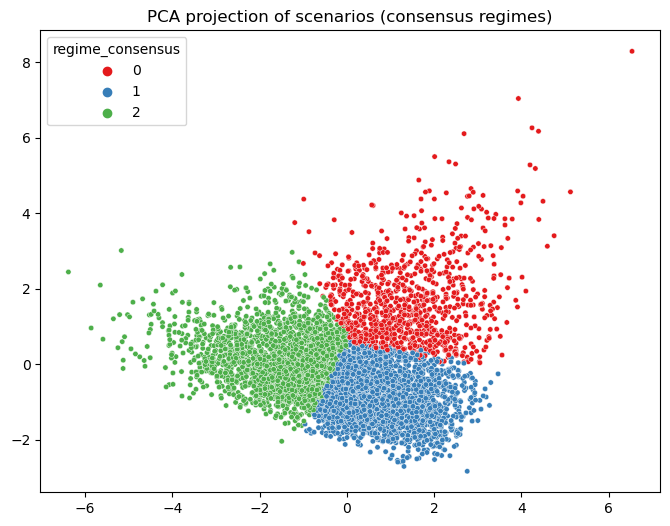

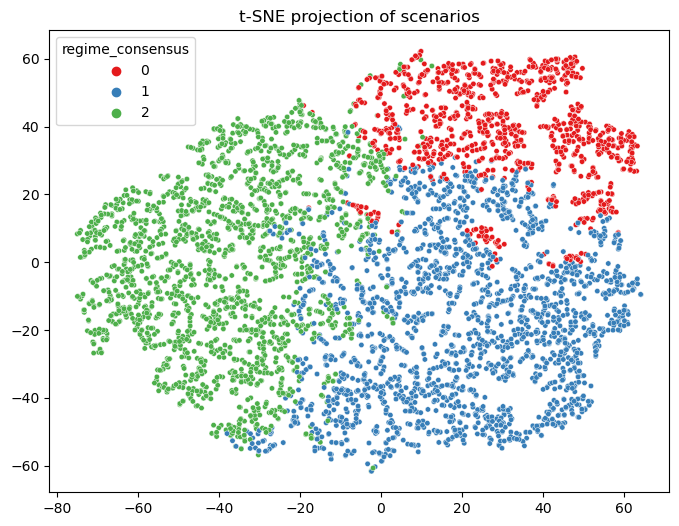

In [44]:
# --- Cell 6: Visualization ---

pca = PCA(n_components=2).fit_transform(Xz)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=feat_df["regime_consensus"], palette="Set1", s=15)
plt.title("PCA projection of scenarios (consensus regimes)")
plt.show()

# Optional TSNE (slow)
tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(Xz)
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=feat_df["regime_consensus"], palette="Set1", s=15)
plt.title("t-SNE projection of scenarios")
plt.show()


Regime Interperatability 


=== Regime interpretability summary ===
                  port_mean  port_std  port_skew  port_kurt  port_mdd  \
regime_consensus                                                        
0                     0.001    0.0001     -0.785     1.2374       0.0   
1                     0.001    0.0001      0.009    -0.3660       0.0   
2                     0.001    0.0002     -0.042    -0.4945       0.0   

                  dd_duration  ewma_vol  xsec_corr  sharpe_like  
regime_consensus                                                 
0                         0.0    0.0001     0.0691       7.5648  
1                         0.0    0.0001     0.0421       8.1096  
2                         0.0    0.0002     0.1401       5.8077  


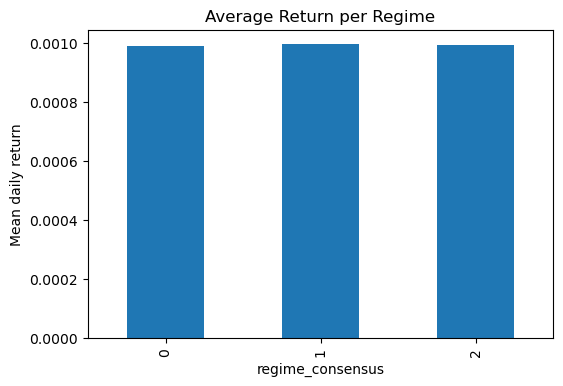

In [45]:
# --- Cell 7: Regime Interpretability ---

interp = feat_df.groupby("regime_consensus").agg({
    "port_mean":   "mean",
    "port_std":    "mean",
    "port_skew":   "mean",
    "port_kurt":   "mean",
    "port_mdd":    "mean",
    "dd_duration": "mean",
    "ewma_vol":    "mean",
    "xsec_corr":   "mean"
})

# Add Sharpe-like metric
interp["sharpe_like"] = interp["port_mean"] / interp["port_std"].replace(0, np.nan)

print("=== Regime interpretability summary ===")
print(interp.round(4))

# Plot quick bar chart of average returns by regime
interp["port_mean"].plot(kind="bar", figsize=(6,4), title="Average Return per Regime")
plt.ylabel("Mean daily return")
plt.show()


Robustness Validation 


In [46]:
# --- Cell 8: Robustness Validation ---

# (1) Bootstrap already gave us ARI across runs
print(f"Bootstrap ARI mean: {np.mean(ari_vals):.3f}")

# (2) Feature sensitivity: drop one feature at a time and re-cluster
sens_scores = {}
for col in feat_df.columns:
    if col in ["kmeans_label", "regime_consensus"]: 
        continue
    X_sub = feat_df.drop(columns=[col])
    X_subz = StandardScaler().fit_transform(X_sub)
    km_sub = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X_subz)
    score = adjusted_rand_score(feat_df["regime_consensus"], km_sub.labels_)
    sens_scores[col] = score

print("Feature sensitivity (ARI vs consensus):")
for k,v in sens_scores.items():
    print(f"  drop {k:<12} → ARI={v:.3f}")

# (3) Train/test split stability
N = len(feat_df)
idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)
train, test = idx[:int(0.7*N)], idx[int(0.7*N):]

km_train = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X_arr[train])
km_test  = KMeans(n_clusters=3, init=km_train.cluster_centers_, n_init=1).fit(X_arr[test])
test_ari = adjusted_rand_score(km_test.labels_, feat_df.iloc[test]["regime_consensus"])
print(f"Train/Test regime stability ARI = {test_ari:.3f}")


Bootstrap ARI mean: 0.974
Feature sensitivity (ARI vs consensus):
  drop port_mean    → ARI=1.000
  drop port_std     → ARI=0.992
  drop port_skew    → ARI=0.957
  drop port_kurt    → ARI=0.983
  drop port_mdd     → ARI=1.000
  drop dd_duration  → ARI=1.000
  drop ewma_vol     → ARI=0.980
  drop xsec_corr    → ARI=0.946
Train/Test regime stability ARI = 0.934


c:\Users\Krish\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  If a sparse matrix is passed, a copy will be made if it's not in


Save for week 4


In [47]:
# --- Cell 10: Save Outputs for Week 4 ---

OUT_FP = WEEK3_DIR / "features_week3.parquet"
feat_df.to_parquet(OUT_FP)
print("Saved feature matrix with regimes →", OUT_FP)

# Also save as CSV for inspection
feat_df.to_csv(WEEK3_DIR / "features_week3.csv")


Saved feature matrix with regimes → C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_3\features_week3.parquet
